In [43]:
# "https://helioconvert-sdo.s3.us-east-1.amazonaws.com/fits2asdf/data_selection/asdf/aia.lev1_euv_12s.2014-02-20T110710Z.131.image_lev1.asdf"

In [54]:
import asdf

url = "https://helioconvert-sdo.s3.us-east-1.amazonaws.com/fits2asdf/data_selection/aia.lev1_euv_12s.2014-01-07T192810Z.131.image_lev1.asdf"

# Fields to extract
shared_fields = [
    "boundbox_c1ll", "boundbox_c1ur", "boundbox_c2ll", "boundbox_c2ur",
    "event_starttime", "event_endtime", "hpc_coord", "hpc_bbox", "hpc_radius",
    "hv_hpc_x_final", "hv_hpc_y_final", "hv_labels_formatted", "frm_name",
    "obs_observatory", "obs_instrument", "obs_channelid", "frm_url", "event_type"
]
flare_fields = shared_fields + ["fl_peakflux", "fl_peakfluxunit", "event_peaktime"]

# Open and parse the ASDF file
with asdf.open(url, lazy_load=True) as af:
    tree = af.tree
    
    # --- Basic Preview ---
    label = tree["meta"]["image_label"]
    data_source = tree["fits"]["hdu1"]["data"]  # string (S3 npy URL or null)
    print("Label:", label)
    print("\n ---------------------")
    print("Data Source URL:", data_source)
    print("\n ---------------------")
    
    
    hek = tree["hek"]  # hek is a list of 1+ dicts

    for hek_entry in hek:
        if "groups" not in hek_entry:
            continue

        for group in hek_entry["groups"]:
            for event in group.get("data", []):
                if event.get("event_type") == "FL":  # Target flare
                    print("⚡ Flare event found!\n")

                    for field in flare_fields:
                        value = event.get(field, "N/A")
                        print(f"{field}: {value}")
                    
                    print("\n" + "-"*40 + "\n")

Label: 1

 ---------------------
Data Source URL: https://helioconvert-sdo.s3.us-east-1.amazonaws.com/fits2asdf/data_selection/fits/data/aia.lev1_euv_12s.2014-01-07T150810Z.131.image_lev1_data.npy

 ---------------------
⚡ Flare event found!

boundbox_c1ll: -1377
boundbox_c1ur: 1374
boundbox_c2ll: -1227
boundbox_c2ur: 1229
event_starttime: 2014-01-07T17:30:35
event_endtime: 2014-01-08T03:30:35
hpc_coord: POINT(-1 1)
hpc_bbox: POLYGON((-1377 -1227,1374 -1227,1374 1229,-1377 1229,-1377 -1227))
hpc_radius: 1.41421356237309515
hv_hpc_x_final: 17.284098975250107
hv_hpc_y_final: 1.1241635985481933
hv_labels_formatted: []
frm_name: slater
obs_observatory: SDO
obs_instrument: HEK
obs_channelid: FL
frm_url: n/a
event_type: FL
fl_peakflux: None
fl_peakfluxunit: 
event_peaktime: 2014-01-07T18:20:00

----------------------------------------

⚡ Flare event found!

boundbox_c1ll: -1377
boundbox_c1ur: 1374
boundbox_c2ll: -1227
boundbox_c2ur: 1229
event_starttime: 2014-01-07T17:30:35
event_endtime: 20

In [45]:
import asdf
import numpy as np
import requests
import json
from io import BytesIO
import matplotlib.pyplot as plt
import time
import io

# === Arcsec to Pixel Conversion Using WCS ===
def arcsec_to_pixel(x_arcsec, y_arcsec, header):
    CRPIX1 = float(header["CRPIX1"])
    CRPIX2 = float(header["CRPIX2"])
    CRVAL1 = float(header["CRVAL1"])
    CRVAL2 = float(header["CRVAL2"])
    CDELT1 = float(header["CDELT1"])
    CDELT2 = float(header["CDELT2"])

    x_pixel = CRPIX1 + (x_arcsec - CRVAL1) / CDELT1
    y_pixel = CRPIX2 + (y_arcsec - CRVAL2) / CDELT2
    return int(round(x_pixel)), int(round(y_pixel))


# === Pixel to Arcsec Conversion Using WCS ===
def pixel_to_arcsec(x_pixel, y_pixel, header):
    CRPIX1 = float(header["CRPIX1"])
    CRPIX2 = float(header["CRPIX2"])
    CRVAL1 = float(header["CRVAL1"])
    CRVAL2 = float(header["CRVAL2"])
    CDELT1 = float(header["CDELT1"])
    CDELT2 = float(header["CDELT2"])

    x_arcsec = CRVAL1 + (x_pixel - CRPIX1) * CDELT1
    y_arcsec = CRVAL2 + (y_pixel - CRPIX2) * CDELT2
    return x_arcsec, y_arcsec


# === 512×512 Cutout with Black Padding if on Limb ===
def centered_cutout_with_padding(image, center_x_arcsec, center_y_arcsec, header, size=512):
    h, w = image.shape
    cutout = np.zeros((size, size), dtype=image.dtype)

    cx, cy = arcsec_to_pixel(center_x_arcsec, center_y_arcsec, header)
    half = size // 2

    # Define bounds in source image
    x0, x1 = cx - half, cx + half
    y0, y1 = cy - half, cy + half

    # Overlapping region with image
    x0_img = max(x0, 0)
    x1_img = min(x1, w)
    y0_img = max(y0, 0)
    y1_img = min(y1, h)

    # Placement in cutout
    x0_cut = x0_img - x0
    y0_cut = y0_img - y0
    x1_cut = x0_cut + (x1_img - x0_img)
    y1_cut = y0_cut + (y1_img - y0_img)

    # Fill cutout
    cutout[y0_cut:y1_cut, x0_cut:x1_cut] = image[y0_img:y1_img, x0_img:x1_img]
    return cutout, size


def centered_cutout_no_padding(image, center_x_arcsec, center_y_arcsec, header, size=512):
    h, w = image.shape
    cx, cy = arcsec_to_pixel(center_x_arcsec, center_y_arcsec, header)
    half = size // 2

    # Use int, not round — and check bounds with strict clipping
    cx = int(cx)
    cy = int(cy)

    x0 = cx - half
    x1 = cx + half
    y0 = cy - half
    y1 = cy + half

    # If bounds are out of image range, return padded cutout instead
    if x0 < 0 or y0 < 0 or x1 > w or y1 > h:
        print(f"⚠️ Cutout out of bounds: cx={cx}, cy={cy}, image size={w}×{h}")
        return None, size

    cutout = image[y0:y1, x0:x1]
    return cutout, size


In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_cutout(image, header,
                           x0_arcsec, y0_arcsec, x1_arcsec, y1_arcsec,format_type,
                           hek_bbox_arcsec=None,
                           title=None):
    """
    Plots the full solar image with:
    - red rectangle: the cutout region
    - green rectangle: optional HEK bounding box region
    """

    fig, ax = plt.subplots(figsize=(8, 8))
    
    # ✅ Normalize image for display only (visual clarity)
    display_image = image.astype(np.float32)
    display_image /= np.max(display_image) if np.max(display_image) != 0 else 1

    ax.imshow(display_image, cmap="gray", origin="lower")

    # --- Red: Cutout Region ---
    x0_pix, y0_pix = arcsec_to_pixel(x0_arcsec, y0_arcsec, header)
    x1_pix, y1_pix = arcsec_to_pixel(x1_arcsec, y1_arcsec, header)
    red_x = min(x0_pix, x1_pix)
    red_y = min(y0_pix, y1_pix)
    red_w = abs(x1_pix - x0_pix)
    red_h = abs(y1_pix - y0_pix)
    red_rect = patches.Rectangle((red_x, red_y), red_w, red_h,
                                 linewidth=2, edgecolor='red', facecolor='none', label='Cutout')
    ax.add_patch(red_rect)

    # --- Green: HEK BBox (Optional) ---
    if hek_bbox_arcsec:
        hx0, hx1, hy0, hy1 = hek_bbox_arcsec
        hx0_pix, hy0_pix = arcsec_to_pixel(hx0, hy0, header)
        hx1_pix, hy1_pix = arcsec_to_pixel(hx1, hy1, header)
        green_x = min(hx0_pix, hx1_pix)
        green_y = min(hy0_pix, hy1_pix)
        green_w = abs(hx1_pix - hx0_pix)
        green_h = abs(hy1_pix - hy0_pix)
        green_rect = patches.Rectangle((green_x, green_y), green_w, green_h,
                                       linewidth=2, edgecolor='lime', facecolor='none', linestyle='--', label='HEK BBox')
        ax.add_patch(green_rect)

    if title:
        ax.set_title(title)
        ax.set_xlabel("X (pixels)")
        ax.set_ylabel("Y (pixels)")
        ax.legend()
        plt.savefig(f"cutouts/images/{format_type}/full_annotations/{title}.png", bbox_inches='tight', dpi=300) 
        plt.show()

✅ Attempting cutout at (tx, ty) = (2042.9, 1040.4)


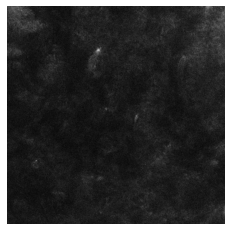

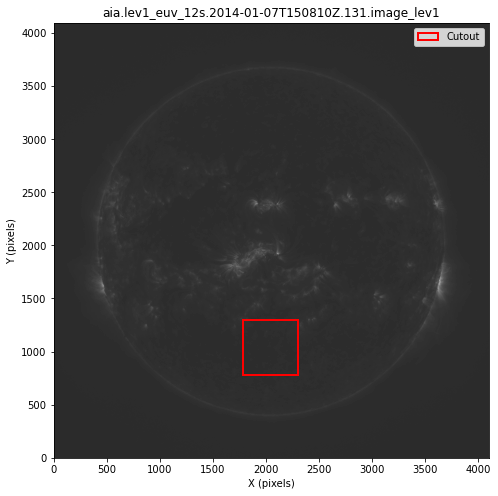

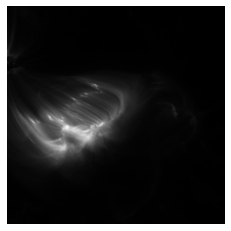

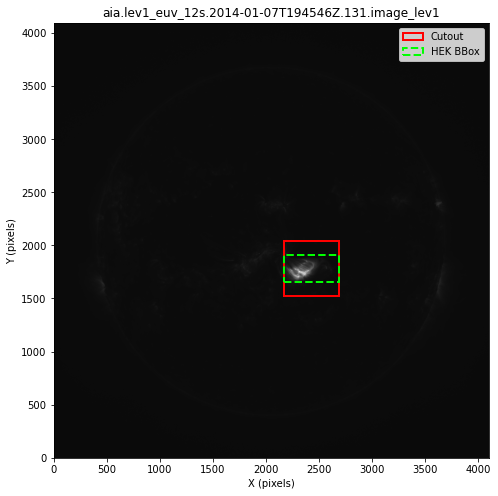

✅ Attempting cutout at (tx, ty) = (2042.9, 1041.3)


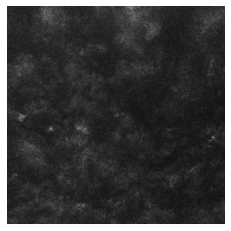

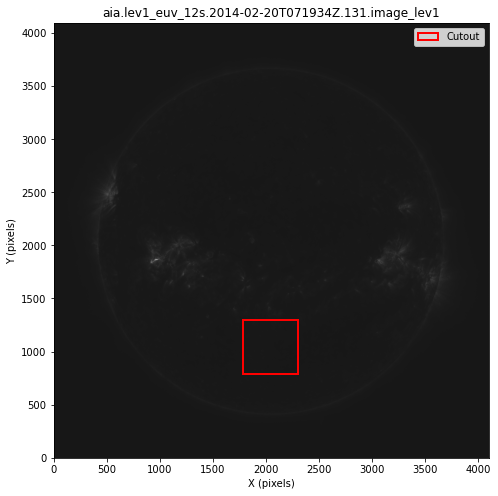

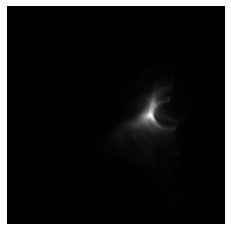

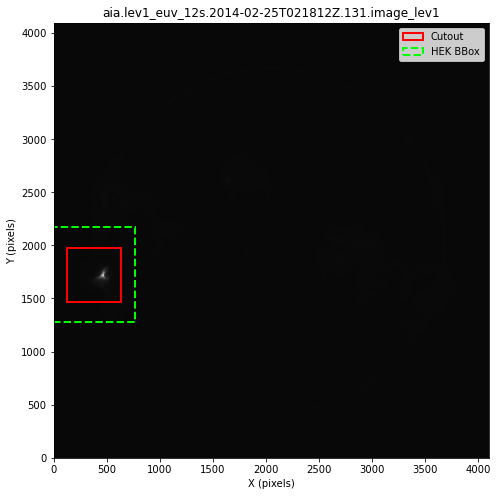


✅ Cutout summary saved to cutouts/cutout_logs/asdf_cutout_log.csv


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, requests
import asdf
from io import BytesIO

# CSV for output logging
log_csv = "cutouts/cutout_logs/asdf_cutout_log.csv"
log_rows = []

# CSV of image labels
df = pd.read_csv("https://helioconvert-sdo.s3.amazonaws.com/fits2asdf/data_selection/image_labels_2.csv")
label_map = dict(zip(df["filename"], df["label"]))

# Helper: convert filename to ASDF URL
def to_asdf_url(filename):
    base = filename.replace(".fits", "")
    return f"https://helioconvert-sdo.s3.amazonaws.com/fits2asdf/data_selection/asdf/{base}.asdf"

# Main cutout function
def crop_flare_cutout_asdf(filename):
    label = label_map.get(filename, -1)
    if label == -1:
        print(f"⚠️ Skipping: Label not found for {filename}")
        return

    asdf_url = to_asdf_url(filename)
    start = time.time()

    try:
        with asdf.open(asdf_url, lazy_load=True) as af:
            tree = af.tree
            header = tree["fits"]["hdu1"]["header"]
            image_url = tree["fits"]["hdu1"]["data"]
            hek = tree["hek"]
    except Exception as e:
        print(f"❌ Failed to open ASDF: {e}")
        return

    image = np.load(BytesIO(requests.get(image_url).content))

    flare_bbox = None
    avoid_boxes = []

    for entry in hek:
        for group in entry.get("groups", []):
            if group.get("name", "").lower() == "slater":
                continue  # Skip over large placeholder boxes
            for e in group.get("data", []):
                if e.get("event_type") == "FL":
                    box = [e["boundbox_c1ll"], e["boundbox_c1ur"], e["boundbox_c2ll"], e["boundbox_c2ur"]]
                    if label == 1 and flare_bbox is None:
                        flare_bbox = box
                    avoid_boxes.append(box)

    if label == 1:
        if not flare_bbox:
            print("❌ No flare event found for label=1")
            return
        
        # Convert arcsec center of HEK bbox to pixel center
        arcsec_cx = (flare_bbox[0] + flare_bbox[1]) / 2
        arcsec_cy = (flare_bbox[2] + flare_bbox[3]) / 2

        # Convert to pixel coordinates
        cx = (arcsec_cx - header["CRVAL1"]) / header["CDELT1"] + header["CRPIX1"]
        cy = (arcsec_cy - header["CRVAL2"]) / header["CDELT2"] + header["CRPIX2"]

        # Now grab 512×512 around that center
        # cutout, size = centered_cutout_with_padding(image, cx, cy, header)
        # cutout, size = centered_cutout_no_padding(image, center_x_arcsec, center_y_arcsec, header)
        # cutout = np.flipud(cutout)
        cutout, size = centered_cutout_no_padding(image, arcsec_cx, arcsec_cy, header)
        cutout = np.flipud(cutout)

        
        bbox_str = str(flare_bbox)

        # Get pixel bounds
        half = size // 2
        x0, x1 = int(cx) - half, int(cx) + half
        y0, y1 = int(cy) - half, int(cy) + half
        x0_arcsec, y0_arcsec = pixel_to_arcsec(x0, y0, header)
        x1_arcsec, y1_arcsec = pixel_to_arcsec(x1, y1, header)
        tx, ty = cx, cy
        
    else:
        # Try center first, then random walk outward until we’re outside HEK boxes
        center_x = float(header["CRPIX1"])
        center_y = float(header["CRPIX2"])
        step = 200
        found = False

        # dy loop comes first to prioritize vertical movement
        for offset in range(1000, 2000, step):
            for direction in [-1, 1]:  # up (-1) then down (+1)
                ty = center_y + direction * offset

                for dx in range(0, 2000, step):
                    for sx in [-1, 1]:  # left then right
                        tx = center_x + sx * dx

                        overlaps = False
                        for box in avoid_boxes:
                            xll_pix = (box[0] - header["CRVAL1"]) / header["CDELT1"] + header["CRPIX1"]
                            xur_pix = (box[1] - header["CRVAL1"]) / header["CDELT1"] + header["CRPIX1"]
                            yll_pix = (box[2] - header["CRVAL2"]) / header["CDELT2"] + header["CRPIX2"]
                            yur_pix = (box[3] - header["CRVAL2"]) / header["CDELT2"] + header["CRPIX2"]

                            if xll_pix <= tx <= xur_pix and yll_pix <= ty <= yur_pix:
                                overlaps = True
                                break

                        if not overlaps:
                            center_x_arcsec, center_y_arcsec = pixel_to_arcsec(tx, ty, header)
                            cutout, size = centered_cutout_no_padding(image, center_x_arcsec, center_y_arcsec, header)
                            cutout = np.flipud(cutout)

                            cx, cy = tx, ty
                            half = size // 2
                            x0, x1 = int(cx) - half, int(cx) + half
                            y0, y1 = int(cy) - half, int(cy) + half
                            x0_arcsec, y0_arcsec = pixel_to_arcsec(x0, y0, header)
                            x1_arcsec, y1_arcsec = pixel_to_arcsec(x1, y1, header)

                            print(f"✅ Attempting cutout at (tx, ty) = ({tx:.1f}, {ty:.1f})")
                            found = True
                            break
                    if found:
                        break
                if found:
                    break
            if found:
                break

        if not found:
            print("⚠️ Could not find clean region for label=0")
            return
        bbox_str = ""

    if cutout is not None:
        cutout = cutout.astype(np.float32)
        cutout /= np.max(cutout) if np.max(cutout) != 0 else 1
        end = time.time()
        log_rows.append({
            "asdf_filename": filename,
            "label": label,
            "hek_bbox": bbox_str,
            "cutout_coords_pix (top-left to bottom-right)": f"(x₀, y₀) = ({x0}, {y0})\n(x₁, y₁) = ({x1}, {y1})",
            "cutout_center_pix": f"({tx:.2f}, {ty:.2f})",
            "cutout_coords_arcsec (top-left to bottom-right)": (
                f"(x₀, y₀) = ({x0_arcsec:.2f}, {y0_arcsec:.2f})\n"
                f"(x₁, y₁) = ({x1_arcsec:.2f}, {y1_arcsec:.2f})"
            ),
            "time_seconds": f"{end - start:.3f}"
        })
        plt.imshow(cutout, cmap="gray")
        # plt.title(f"{filename} | Label={label}")
        plt.axis("off")
        output_path = f"cutouts/images/asdf/cutouts/{filename}.png"
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        
        # plt.savefig(f"cutouts/images/asdf/cutouts/{filename}.png", bbox_inches='tight', dpi=300)
        plt.show()

        plot_image_with_cutout(
            image=image,
            header=header,
            x0_arcsec=x0_arcsec,
            y0_arcsec=y0_arcsec,
            x1_arcsec=x1_arcsec,
            y1_arcsec=y1_arcsec,
            format_type = "asdf",
            hek_bbox_arcsec=flare_bbox if bbox_str else None,
            title = f"{filename.replace('.fits', '')}"
        )

# Run
subset = df["filename"].tolist()[:4]  # or full set
for fname in subset:
    crop_flare_cutout_asdf(fname)

# Save log
pd.DataFrame(log_rows).to_csv(log_csv, index=False)
print(f"\n✅ Cutout summary saved to {log_csv}")



🔍 Processing file: aia.lev1_euv_12s.2014-01-07T150810Z.131.image_lev1.fits
✅ Attempting cutout at (tx, ty) = (2042.9, 1040.4)


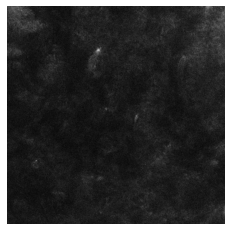

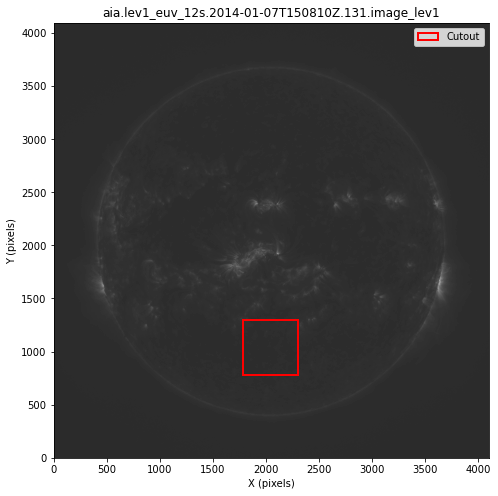

---------------------------------------------------------------------------------------

🔍 Processing file: aia.lev1_euv_12s.2014-01-07T194546Z.131.image_lev1.fits


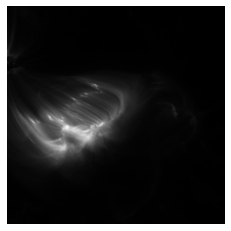

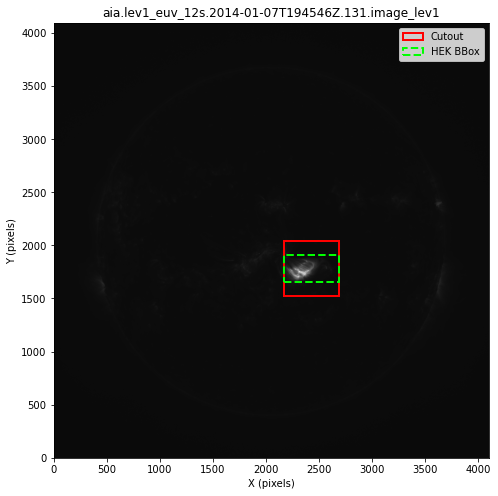

---------------------------------------------------------------------------------------

🔍 Processing file: aia.lev1_euv_12s.2014-02-20T071934Z.131.image_lev1.fits
✅ Attempting cutout at (tx, ty) = (2042.9, 1041.3)


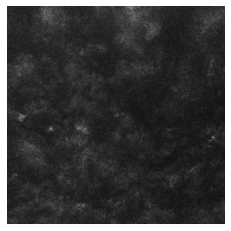

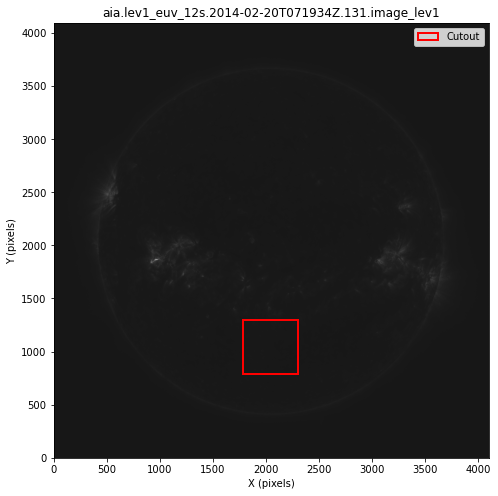

---------------------------------------------------------------------------------------

🔍 Processing file: aia.lev1_euv_12s.2014-02-25T021812Z.131.image_lev1.fits


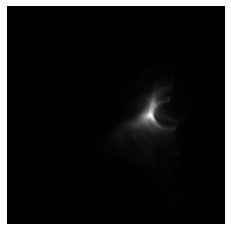

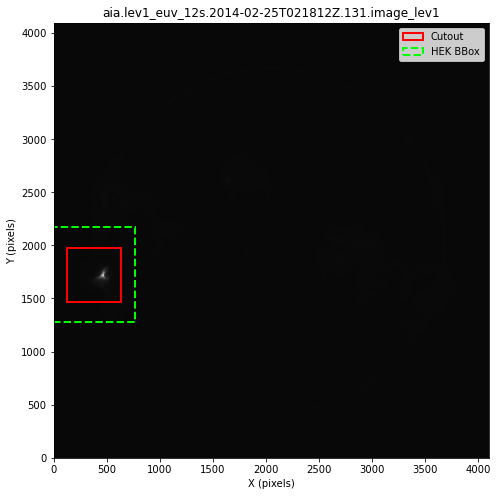

---------------------------------------------------------------------------------------

✅ Cutout summary saved to cutouts/cutout_logs/fits_separate_cutout_log_1.csv


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, requests
import asdf
from io import BytesIO
import os

# CSV for output logging
log_csv = "cutouts/cutout_logs/fits_separate_cutout_log_1.csv"
log_rows = []

# CSV of image labels
# df = pd.read_csv("https://helioconvert-sdo.s3.amazonaws.com/fits2asdf/data_selection/image_labels.csv")
df = pd.read_csv("https://helioconvert-sdo.s3.us-east-1.amazonaws.com/fits2asdf/data_selection/image_labels_2.csv")
label_map = dict(zip(df["filename"], df["label"]))

# === Main Cutout Function ===
def crop_flare_cutout_from_filename(fits_filename):
    label = label_map.get(fits_filename, -1)
    filename = fits_filename
    base = fits_filename.replace(".fits", "")
    image_url = f"https://helioconvert-sdo.s3.us-east-1.amazonaws.com/fits2asdf/data_selection/fits/data/{base}_data.npy"
    header_url = f"https://helioconvert-sdo.s3.us-east-1.amazonaws.com/fits2asdf/data_selection/fits/header/{base}_header.json"
    hek_url = f"https://helioconvert-sdo.s3.us-east-1.amazonaws.com/fits2asdf/data_selection/hek/{base}_hek.json"

    start = time.time()
    print(f"\n🔍 Processing file: {fits_filename}")

    # Load image and header
    image = np.load(BytesIO(requests.get(image_url).content))
    header = requests.get(header_url).json()

    # Load HEK
    try:
        hek = requests.get(hek_url).json()
    except Exception as e:
        print("❌ Failed to load HEK:", e)
        return None

    flare_bbox = None
    avoid_boxes = []
    

    for block in hek:
        if block.get("name", "").lower() == "flare":
            for group in block.get("groups", []):
                if group.get("name", "").lower() == "slater":
                    continue  # Skip over large placeholder boxes
                for entry in group.get("data", []):
                    if entry.get("event_type") == "FL":
                        box = [entry["boundbox_c1ll"], entry["boundbox_c1ur"],
                               entry["boundbox_c2ll"], entry["boundbox_c2ur"]]
                        if label == 1 and flare_bbox is None:
                            flare_bbox = box
                        avoid_boxes.append(box)

    if label == 1:
        if not flare_bbox:
            print("❌ No flare event found for label=1")
            return
        
        # Convert arcsec center of HEK bbox to pixel center
        arcsec_cx = (flare_bbox[0] + flare_bbox[1]) / 2
        arcsec_cy = (flare_bbox[2] + flare_bbox[3]) / 2

        # Convert to pixel coordinates
        cx = (arcsec_cx - header["CRVAL1"]) / header["CDELT1"] + header["CRPIX1"]
        cy = (arcsec_cy - header["CRVAL2"]) / header["CDELT2"] + header["CRPIX2"]

        # Now grab 512×512 around that center
        # cutout, size = centered_cutout_with_padding(image, cx, cy, header)
        # cutout, size = centered_cutout_no_padding(image, center_x_arcsec, center_y_arcsec, header)
        # cutout = np.flipud(cutout)
        cutout, size = centered_cutout_no_padding(image, arcsec_cx, arcsec_cy, header)
        cutout = np.flipud(cutout)

        
        bbox_str = str(flare_bbox)

        # Get pixel bounds
        half = size // 2
        x0, x1 = int(cx) - half, int(cx) + half
        y0, y1 = int(cy) - half, int(cy) + half
        x0_arcsec, y0_arcsec = pixel_to_arcsec(x0, y0, header)
        x1_arcsec, y1_arcsec = pixel_to_arcsec(x1, y1, header)
        tx, ty = cx, cy

    else:
        center_x = float(header["CRPIX1"])
        center_y = float(header["CRPIX2"])
        step = 200
        found = False

        # dy loop comes first to prioritize vertical movement
        for offset in range(1000, 2000, step):
            for direction in [-1, 1]:  # up (-1) then down (+1)
                ty = center_y + direction * offset

                for dx in range(0, 2000, step):
                    for sx in [-1, 1]:  # left then right
                        tx = center_x + sx * dx

                        overlaps = False
                        for box in avoid_boxes:
                            xll_pix = (box[0] - header["CRVAL1"]) / header["CDELT1"] + header["CRPIX1"]
                            xur_pix = (box[1] - header["CRVAL1"]) / header["CDELT1"] + header["CRPIX1"]
                            yll_pix = (box[2] - header["CRVAL2"]) / header["CDELT2"] + header["CRPIX2"]
                            yur_pix = (box[3] - header["CRVAL2"]) / header["CDELT2"] + header["CRPIX2"]

                            if xll_pix <= tx <= xur_pix and yll_pix <= ty <= yur_pix:
                                overlaps = True
                                break

                        if not overlaps:
                            center_x_arcsec, center_y_arcsec = pixel_to_arcsec(tx, ty, header)
                            cutout, size = centered_cutout_no_padding(image, center_x_arcsec, center_y_arcsec, header)
                            cutout = np.flipud(cutout)

                            cx, cy = tx, ty
                            half = size // 2
                            x0, x1 = int(cx) - half, int(cx) + half
                            y0, y1 = int(cy) - half, int(cy) + half
                            x0_arcsec, y0_arcsec = pixel_to_arcsec(x0, y0, header)
                            x1_arcsec, y1_arcsec = pixel_to_arcsec(x1, y1, header)

                            print(f"✅ Attempting cutout at (tx, ty) = ({tx:.1f}, {ty:.1f})")
                            found = True
                            break
                    if found:
                        break
                if found:
                    break
            if found:
                break
                
        if not found:
            print("⚠️ Could not find clean region for label=0")
            return
        bbox_str = ""

    # Finalize if cutout exists
    if cutout is not None:
        cutout = cutout.astype(np.float32)
        cutout /= np.max(cutout) if np.max(cutout) != 0 else 1
        end = time.time()

        log_rows.append({
            "fits_filename": fits_filename,
            "label": label,
            "hek_bbox": bbox_str,
            "cutout_coords_pix (top-left to bottom-right)": f"(x₀, y₀) = ({x0}, {y0})\n(x₁, y₁) = ({x1}, {y1})",
            "cutout_center_pix": f"({tx:.2f}, {ty:.2f})",
            "cutout_coords_arcsec (top-left to bottom-right)": (
                f"(x₀, y₀) = ({x0_arcsec:.2f}, {y0_arcsec:.2f})\n"
                f"(x₁, y₁) = ({x1_arcsec:.2f}, {y1_arcsec:.2f})"
            ),
            "time_seconds": f"{end - start:.3f}"
        })

        # Show cutout
        plt.imshow(cutout, cmap="gray")
        # plt.title(f"{filename} | Label={label}")
        plt.axis("off")
        output_path = f"cutouts/images/fits_separate/cutouts/{filename}.png"
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        # plt.savefig(f"cutouts/images/fits_separate/cutouts/{filename}.png", bbox_inches='tight', dpi=300)
        plt.show()

        # Show full image with overlay
        plot_image_with_cutout(
            image=image,
            header=header,
            x0_arcsec=x0_arcsec,
            y0_arcsec=y0_arcsec,
            x1_arcsec=x1_arcsec,
            y1_arcsec=y1_arcsec,
            format_type = "fits_separate",
            hek_bbox_arcsec=flare_bbox if bbox_str else None,
            title = f"{filename.replace('.fits', '')}"
        )
        print("---------------------------------------------------------------------------------------")     

   
        
# Run
subset = df["filename"].tolist()[:4]  # Replace with full list when ready
for fname in subset:
    crop_flare_cutout_from_filename(fname)

# Save log
pd.DataFrame(log_rows).to_csv(log_csv, index=False)
print(f"\n✅ Cutout summary saved to {log_csv}")


🔍 Processing file: aia.lev1_euv_12s.2014-01-07T150810Z.131.image_lev1.fits
✅ Attempting cutout at (tx, ty) = (2042.9, 1040.4)


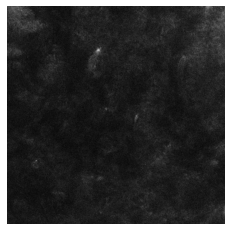

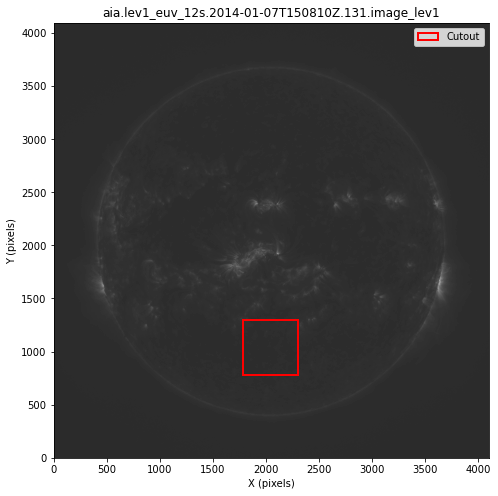


🔍 Processing file: aia.lev1_euv_12s.2014-01-07T194546Z.131.image_lev1.fits


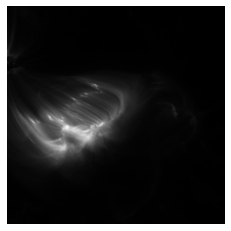

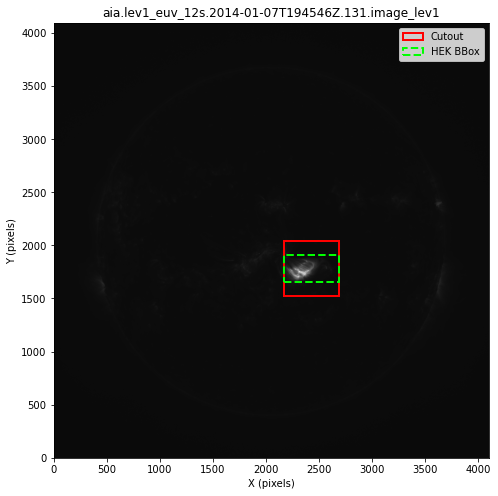


🔍 Processing file: aia.lev1_euv_12s.2014-02-20T071934Z.131.image_lev1.fits
✅ Attempting cutout at (tx, ty) = (2042.9, 1041.3)


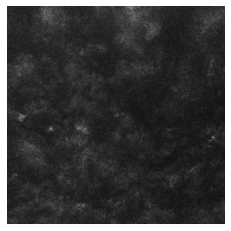

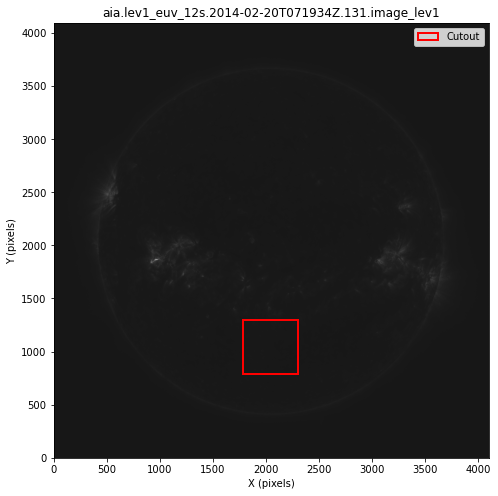


🔍 Processing file: aia.lev1_euv_12s.2014-02-25T021812Z.131.image_lev1.fits


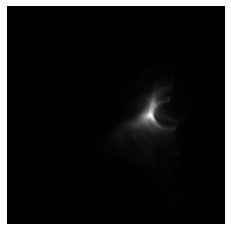

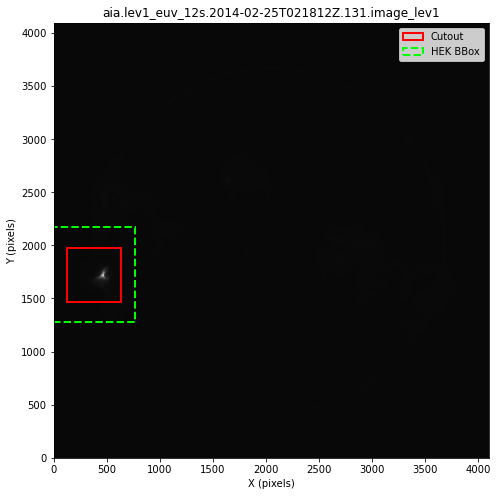


✅ Cutout summary saved to cutouts/cutout_logs/fits_cutout_log.csv


In [79]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, requests
import asdf
from io import BytesIO

# CSV for output logging
log_csv = "cutouts/cutout_logs/fits_cutout_log.csv"
log_rows = []

# CSV of image labels
df = pd.read_csv("https://helioconvert-sdo.s3.amazonaws.com/fits2asdf/data_selection/image_labels_2.csv")
label_map = dict(zip(df["filename"], df["label"]))

# === Main Cutout Function ===
def crop_flare_cutout_from_filename(fits_filename):
    label = label_map.get(fits_filename, -1)
    filename = fits_filename
    base = fits_filename.replace(".fits", "")
    fits_url    = f"https://helioconvert-sdo.s3.us-east-1.amazonaws.com/fits2asdf/data_selection/fits/raw/{base}.fits"
    header_url  = f"https://helioconvert-sdo.s3.us-east-1.amazonaws.com/fits2asdf/data_selection/fits/header/{base}_header.json"
    hek_url     = f"https://helioconvert-sdo.s3.us-east-1.amazonaws.com/fits2asdf/data_selection/hek/{base}_hek.json"

    start = time.time()
    print(f"\n🔍 Processing file: {fits_filename}")

    ##########################################################################
    hdul = fits.open(fits_url)
    hdul.verify('fix')
    hdu = hdul[1] if len(hdul) > 1 and hdul[1].data is not None else hdul[0]
    # data = hdu.data
    # image = np.load(BytesIO(requests.get(hdu.data).content))
    image = hdu.data
    header = hdu.header 
    hdul.close()   
    ##########################################################################

    # Load HEK
    try:
        hek = requests.get(hek_url).json()
    except Exception as e:
        print("❌ Failed to load HEK:", e)
        return None

    flare_bbox = None
    avoid_boxes = []


    for block in hek:
        if block.get("name", "").lower() == "flare":
            for group in block.get("groups", []):
                if group.get("name", "").lower() == "slater":
                    continue  # Skip over large placeholder boxes
                for entry in group.get("data", []):
                    if entry.get("event_type") == "FL":
                        box = [entry["boundbox_c1ll"], entry["boundbox_c1ur"],
                               entry["boundbox_c2ll"], entry["boundbox_c2ur"]]
                        if label == 1 and flare_bbox is None:
                            flare_bbox = box
                        avoid_boxes.append(box)


    if label == 1:
        if not flare_bbox:
            print("❌ No flare event found for label=1")
            return
        
        # Convert arcsec center of HEK bbox to pixel center
        arcsec_cx = (flare_bbox[0] + flare_bbox[1]) / 2
        arcsec_cy = (flare_bbox[2] + flare_bbox[3]) / 2

        # Convert to pixel coordinates
        cx = (arcsec_cx - header["CRVAL1"]) / header["CDELT1"] + header["CRPIX1"]
        cy = (arcsec_cy - header["CRVAL2"]) / header["CDELT2"] + header["CRPIX2"]

        # Now grab 512×512 around that center
        # cutout, size = centered_cutout_with_padding(image, cx, cy, header)
        # cutout, size = centered_cutout_no_padding(image, center_x_arcsec, center_y_arcsec, header)
        # cutout = np.flipud(cutout)
        cutout, size = centered_cutout_no_padding(image, arcsec_cx, arcsec_cy, header)
        cutout = np.flipud(cutout)

        
        bbox_str = str(flare_bbox)

        # Get pixel bounds
        half = size // 2
        x0, x1 = int(cx) - half, int(cx) + half
        y0, y1 = int(cy) - half, int(cy) + half
        x0_arcsec, y0_arcsec = pixel_to_arcsec(x0, y0, header)
        x1_arcsec, y1_arcsec = pixel_to_arcsec(x1, y1, header)
        tx, ty = cx, cy

    else:
        center_x = float(header["CRPIX1"])
        center_y = float(header["CRPIX2"])
        step = 200
        found = False

        # dy loop comes first to prioritize vertical movement
        for offset in range(1000, 2000, step):
            for direction in [-1, 1]:  # up (-1) then down (+1)
                ty = center_y + direction * offset

                for dx in range(0, 2000, step):
                    for sx in [-1, 1]:  # left then right
                        tx = center_x + sx * dx

                        overlaps = False
                        for box in avoid_boxes:
                            xll_pix = (box[0] - header["CRVAL1"]) / header["CDELT1"] + header["CRPIX1"]
                            xur_pix = (box[1] - header["CRVAL1"]) / header["CDELT1"] + header["CRPIX1"]
                            yll_pix = (box[2] - header["CRVAL2"]) / header["CDELT2"] + header["CRPIX2"]
                            yur_pix = (box[3] - header["CRVAL2"]) / header["CDELT2"] + header["CRPIX2"]

                            if xll_pix <= tx <= xur_pix and yll_pix <= ty <= yur_pix:
                                overlaps = True
                                break

                        if not overlaps:
                            center_x_arcsec, center_y_arcsec = pixel_to_arcsec(tx, ty, header)
                            cutout, size = centered_cutout_no_padding(image, center_x_arcsec, center_y_arcsec, header)
                            cutout = np.flipud(cutout)

                            cx, cy = tx, ty
                            half = size // 2
                            x0, x1 = int(cx) - half, int(cx) + half
                            y0, y1 = int(cy) - half, int(cy) + half
                            x0_arcsec, y0_arcsec = pixel_to_arcsec(x0, y0, header)
                            x1_arcsec, y1_arcsec = pixel_to_arcsec(x1, y1, header)

                            print(f"✅ Attempting cutout at (tx, ty) = ({tx:.1f}, {ty:.1f})")
                            found = True
                            break
                    if found:
                        break
                if found:
                    break
            if found:
                break

        if not found:
            print("⚠️ Could not find clean region for label=0")
            return
        bbox_str = ""

    # Finalize if cutout exists
    if cutout is not None:
        cutout = cutout.astype(np.float32)
        cutout /= np.max(cutout) if np.max(cutout) != 0 else 1
        end = time.time()

        log_rows.append({
            "fits_filename": fits_filename,
            "label": label,
            "hek_bbox": bbox_str,
            "cutout_coords_pix (top-left to bottom-right)": f"(x₀, y₀) = ({x0}, {y0})\n(x₁, y₁) = ({x1}, {y1})",
            "cutout_center_pix": f"({tx:.2f}, {ty:.2f})",
            "cutout_coords_arcsec (top-left to bottom-right)": (
                f"(x₀, y₀) = ({x0_arcsec:.2f}, {y0_arcsec:.2f})\n"
                f"(x₁, y₁) = ({x1_arcsec:.2f}, {y1_arcsec:.2f})"
            ),
            "time_seconds": f"{end - start:.3f}"
        })

        # Show cutout
        plt.imshow(cutout, cmap="gray")
        # plt.title(f"{filename} | Label={label}")
        plt.axis("off")
        output_path = f"cutouts/images/fits/cutouts/{filename}.png"
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        plt.show()

        # Show full image with overlay
        plot_image_with_cutout(
            image=image,
            header=header,
            x0_arcsec=x0_arcsec,
            y0_arcsec=y0_arcsec,
            x1_arcsec=x1_arcsec,
            y1_arcsec=y1_arcsec,
            format_type = "fits",
            hek_bbox_arcsec=flare_bbox if bbox_str else None,
            title = f"{filename.replace('.fits', '')}"
        )

# Run
subset = df["filename"].tolist()[:4]  # Replace with full list when ready
for fname in subset:
    crop_flare_cutout_from_filename(fname)

# Save log
pd.DataFrame(log_rows).to_csv(log_csv, index=False)
print(f"\n✅ Cutout summary saved to {log_csv}")